In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
# import tensorflow_probability as tfp
import tensorflow as tf
from uitils import *
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, recall_score, f1_score


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import lightgbm as lgb
print('GPU support:', lgb.LGBMClassifier(device='gpu').get_params()['device'])



Num GPUs Available:  1
GPU support: gpu


# Data Loading

In [3]:
creditcard_path =get_full_path('../datasets/creditcard.csv')
# fraudulent=1 
# unlabeled=0
creditcard_df = pd.read_csv(creditcard_path)
x_train = creditcard_df.drop('Class', axis=1) 
y_train = creditcard_df['Class']

# Separate the positive and negative instances
positives = creditcard_df[creditcard_df['Class'] == 1]
negatives = creditcard_df[creditcard_df['Class'] == 0]

# Randomly sample 10,000 negative examples
neg_sample = negatives.sample(n=100000, random_state=42)

# Concatenate the positive examples with the sampled negative examples
sampled_df = pd.concat([positives, neg_sample])

# Shuffle the dataset to mix up the rows
sampled_df = sampled_df.sample(frac=1, random_state=42)

# Split the features and labels
x_train_sampled = sampled_df.drop('Class', axis=1)
y_train_sampled = sampled_df['Class']

# Split into training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_train_sampled, y_train_sampled, test_size=0.1, random_state=42)

# Print the training labels distribution to verify
print("Training labels distribution:", np.bincount(y_train))




# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
# x_train=x_train[:1000]
# print("Training labels distribution:", np.bincount(y_train))

Training labels distribution: [90004   438]


# Pre-training

In [4]:
import lightgbm as lgb

train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)
params = {
    'boosting_type': 'gbdt',  # Gradient boosting decision tree
    'objective': 'binary',    # Binary classification
    'metric': 'binary_logloss',  # Evaluation metric
    'num_leaves': 31,         # Number of leaves in full tree
    'learning_rate': 0.01,    # Learning rate
    'feature_fraction': 0.9,  # Fraction of features to be used at each iteration
    'bagging_fraction': 0.8,  # Fraction of data to be used for each iteration
    'bagging_freq': 5, 
    'device': 'gpu',       # Frequency for bagging
    'verbose': 1              # Verbose output
}

num_initial_round = 15
model_lgb = lgb.train(params, train_data, num_boost_round=num_initial_round, valid_sets=[test_data])
model_lgb.save_model('lgb_model.we7ights.h5')


y_pred_prob = model_lgb.predict(x_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[LightGBM] [Info] Number of positive: 438, number of negative: 90004
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 90442, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (2.76 MB) transferred to GPU in 0.010493 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004843 -> initscore=-5.325390
[LightGBM] [Info] Start training from score -5.325390
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (2.21 MB) transferred to GPU in 0.008244 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (2.21 MB) transferred to 

### Probablistic outcome of classifer to pre-train policy network
 

In [5]:
# probabilities = model_lgb.predict(x_train)
# threshold = min(probabilities[y_train == 1])

# # Convert probabilities to binary labels based on the threshold
# predicted_labels = (probabilities >= threshold).astype(int)
# clf_predicted_labels = predicted_labels.flatten().astype(int)


y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
threshold = min(y_pred[y_train == 1])
lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

Classifer predicted labels distribution: [ 1776 88666]


In [6]:
# Policy-Network Model

class PolicyGradientNetwork:
    def __init__(self):
        self.model = self._create_model()
    
    def _create_model(self):
        model = Sequential([
            Dense(512, input_shape=(input_dimension,)),  # Adjust `input_dimension` to match your feature count
            Activation('relu'),
            Dense(256),
            Activation('relu'),
            Dense(128),
            Activation('relu'),
            Dense(64),
            Activation('relu'),
            Dense(32),
            Activation('relu'),
            Dense(16),
            Activation('relu'),
            Dense(1),  # Output layer for binary classification
            Activation('sigmoid')
        ])
        return model
    
    def get_model(self):
        return self.model
    
input_dimension = x_train.shape[1]
policy_network = PolicyGradientNetwork()
pn_model = policy_network.get_model()

pn_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with one-hot encoded labels
history_2 = pn_model.fit(x_train.to_numpy(), lgb_predicted_labels, epochs=15, batch_size=128, validation_split=0.2)
pn_model.save_weights('pn_mlp_model_.weights.h5')
# pn_model.load_weights('pn_mlp_model_.weights.h5')

Epoch 1/15
566/566 [==============================] - 23s 36ms/step - loss: 7.2488 - accuracy: 0.9705 - val_loss: 0.1613 - val_accuracy: 0.9805
Epoch 2/15
566/566 [==============================] - 20s 36ms/step - loss: 0.5503 - accuracy: 0.9757 - val_loss: 0.3071 - val_accuracy: 0.9684
Epoch 3/15
566/566 [==============================] - 19s 33ms/step - loss: 1.0051 - accuracy: 0.9710 - val_loss: 0.1372 - val_accuracy: 0.9776
Epoch 4/15
566/566 [==============================] - 17s 31ms/step - loss: 0.1634 - accuracy: 0.9791 - val_loss: 0.1451 - val_accuracy: 0.9807
Epoch 5/15
566/566 [==============================] - 22s 39ms/step - loss: 1.4232 - accuracy: 0.9700 - val_loss: 2.3028 - val_accuracy: 0.9809
Epoch 6/15
566/566 [==============================] - 83s 140ms/step - loss: 0.4184 - accuracy: 0.9765 - val_loss: 0.4099 - val_accuracy: 0.9808
Epoch 7/15
566/566 [==============================] - 84s 148ms/step - loss: 0.6185 - accuracy: 0.9744 - val_loss: 0.2187 - val_accurac

In [7]:
probabilities = pn_model.predict(x_train.to_numpy())
threshold = min(probabilities[y_train == 1])

# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
np_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(np_predicted_labels))

2827/2827 [==============================] - 74s 26ms/step
Classifer predicted labels distribution: [  112 90330]


## Interactive learning

In [8]:
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, model, target_model, alpha=0.00001, gamma=0.99):
        self.gamma = gamma  # Discount factor
        self.lr = alpha  # Learning rate
        self.model = model  # Policy model
        self.target_model = target_model # target policy model
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    
    def choose_action(self, states, s, threshold=0.5):
        # Convert states to float32 tensor within the function
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        probabilities = self.target_model(states) 
        
        inferred_labels = tf.cast(probabilities > threshold, tf.int32)       
        s = tf.reshape(s, tf.shape(inferred_labels))  # Ensuring s is the same shape as inferred_labels
        actions = tf.where(s == 1, 1, inferred_labels)
        actions = tf.squeeze(actions)  # This should correctly squeeze actions to shape (128,)
        return actions.numpy(), probabilities.numpy()


        # actions = tf.cast(tf.random.uniform(tf.shape(probabilities)) < probabilities, tf.int32)
        # return actions.numpy(), probabilities.numpy()


    def store_transition(self, states, actions, rewards):
        self.state_memory.extend(states)
        self.action_memory.extend(actions)
        self.reward_memory.extend(rewards)

    def learn(self):
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        states = np.array(self.state_memory)

        # Calculate discounted rewards
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum

        # Updating policy
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, states)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.model(state, training=True)
                action_probs = tf.where(actions[idx] == 1, probs, 1 - probs)
                log_prob = tf.math.log(action_probs)
                loss += -g * tf.reduce_sum(log_prob)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Clear memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []


In [9]:
# Clone policy model for stable target policy
target_policy_model = tf.keras.models.clone_model(pn_model)
target_policy_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[],
    'recall':[],
    'f1':[]
}

agent = Agent(pn_model,target_model=target_policy_model, alpha=0.00001, gamma=0.99)
# Example parameters
n_epochs = 300
n_epochs = 10
batch_size = 128 # You can adjust the batch size as needed

def shuffle_data(x_train, y_train, s):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    return x_train[indices], y_train[indices], s[indices]

def create_mini_batches(x_train, y_train, s, batch_size):
    for start_idx in range(0, len(x_train) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x_train[excerpt], y_train[excerpt], s[excerpt]

def calculate_threshold(clf_probabilities, y_batch):
    # Identify indices of positive examples
    positive_indices = (y_batch == 1)
    
    # Calculate threshmin from positive examples
    if np.any(positive_indices):
        threshmin = np.min(clf_probabilities[positive_indices])
    else:
        threshmin = 0  # Default value if no positive examples are present

    # Identify U0 - samples with predictions >= threshmin
    U0_indices = (clf_probabilities >= threshmin)
    
    # Calculate the final threshold using Equation 5
    if np.any(U0_indices):
        threshold = np.mean(clf_probabilities[U0_indices])
    else:
        threshold = threshmin  # Use threshmin if no samples meet the U0 criteria

    return threshold

def calculate_rewards(clf_probabilities, y_batch, threshold):
    # Reward calculation needs to consider whether predictions meet a certain threshold
    # Positive examples above threshold or negative examples below threshold get positive rewards
    rewards = []
    for prob, actual in zip(clf_probabilities.flatten(), y_batch):
        if actual == 1 or (actual == 0 and prob >= threshold):
            reward = prob  # Reward is the probability itself if conditions are met
        else:
            reward = prob -1  # Otherwise, reward is the complement of the probability
        rewards.append(reward)
    return rewards

In [11]:
# num_initial_round = 5
# model_lgb = lgb.train(params, train_data, num_boost_round=num_initial_round, valid_sets=[test_data])
# model_lgb.save_model('lgb_model.we7ights.h5')


# y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
# threshold = min(y_pred[y_train == 1])
# lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
# print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

In [12]:
def train_model(x_train, y_train, s, epochs=300, batch_size=128, model_lgb=model_lgb):
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    s = s.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, s))
    dataset = dataset.shuffle(buffer_size=len(x_train)).batch(len(y_train))
    # dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        # lgb_probabilities=None
        threshold = 0.5
        for x_batch, y_batch, s_batch in dataset:
            # Get actions and probabilities for the entire batch
            actions, probabilities = agent.choose_action(x_batch, s_batch, threshold=threshold)
            train_data = lgb.Dataset(x_batch, label=actions)
            valid_data = lgb.Dataset(x_batch, label=actions)
            model_lgb = lgb.train(params, train_data, num_boost_round=1, init_model=model_lgb, keep_training_booster=True)
    

            # Fit the model on the current batch and update history
            # batch_history = model.fit(x_batch, actions, epochs=1, batch_size=len(x_batch), validation_split=0.2)
            # history['batch_loss'].append(batch_history.history['loss'][0])
            # history['batch_accuracy'].append(batch_history.history['accuracy'][0])

            lgb_probabilities = model_lgb.predict(x_batch, num_iteration=model_lgb.best_iteration)
            threshold = calculate_threshold(lgb_probabilities, y_batch)
            rewards = calculate_rewards(lgb_probabilities, y_batch, threshold)

            # Store transitions and learn from them
            agent.store_transition(x_batch.numpy(), actions, rewards)
            agent.learn()
            # break

        y_pred_prob = model_lgb.predict(x_test)
        y_pred = np.where(y_pred_prob > 0.5, 1, 0)

        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("AUC-ROC:", roc_auc)
        history['ROC_AUC'].append(roc_auc)

        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", accuracy)
        history['accuracy'].append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_pred_prob)
        pr_auc = auc(recall, precision)
        history['PR_AUC'].append(pr_auc)
        print("Precision:", pr_auc)

        recall = recall_score(y_test, y_pred)
        print("Recall:", recall)
        history['recall'].append(recall)

        # Calculate F1 score
        f1 = f1_score(y_test, y_pred)
        print("F1 Score:", f1)
        history['f1'].append(f1)


        if epoch % 3 == 0:
            print("Updating target policy...")
            agent.target_model.set_weights(agent.model.get_weights())


train_model(x_train=x_train, y_train=y_train, s=y_train, model_lgb=model_lgb)

Epoch 1/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 438, number of negative: 90004
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 90442, number of used features: 30
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (2.76 MB) transferred to GPU in 0.007103 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (2.21 MB) transferred to GPU in 0.006285 secs. 0 sparse feature groups


In [ ]:
import pickle
with open('history_XGB.pkl', 'wb') as file:
    # Use pickle to dump the dictionary into the file
    pickle.dump(history, file)

with open('history_XGB.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    loaded_history = pickle.load(file)

# Verify the content
print(loaded_history)

{'epoch_loss': [], 'epoch_accuracy': [], 'batch_loss': [], 'batch_accuracy': [], 'predictions': [], 'rewards': [], 'thresholds': [], 'ROC_AUC': [0.994030945711618, 0.9940077883005054, 0.9940429875653966, 0.9951230492196879, 0.9938799593911638, 0.9945820920960975, 0.9940633660871756, 0.993639122315593, 0.9932093207653432, 0.9925849969617476, 0.9925386821395225, 0.9924553154595172, 0.9925942599261928, 0.9924719887955183, 0.9923654647044002, 0.9928286129266523, 0.9927183836497562, 0.9924553154595172, 0.9924034428586249, 0.9919319579683725, 0.9918319179523661, 0.9936789530627066, 0.993812339750715, 0.9937178575133758, 0.9935918811969233, 0.9937336045529325, 0.9937373097387103, 0.9936243015724807, 0.9937336045529322, 0.9937021104738192, 0.9936381960191484, 0.9935214826671411, 0.9931843107613415, 0.9929193899782134, 0.9931176174173373, 0.9947849510174442, 0.9947608673098869, 0.9946858372978822, 0.9946367435863234, 0.9946293332147674, 0.9946219228432112, 0.9945774606138751, 0.9947692039778874

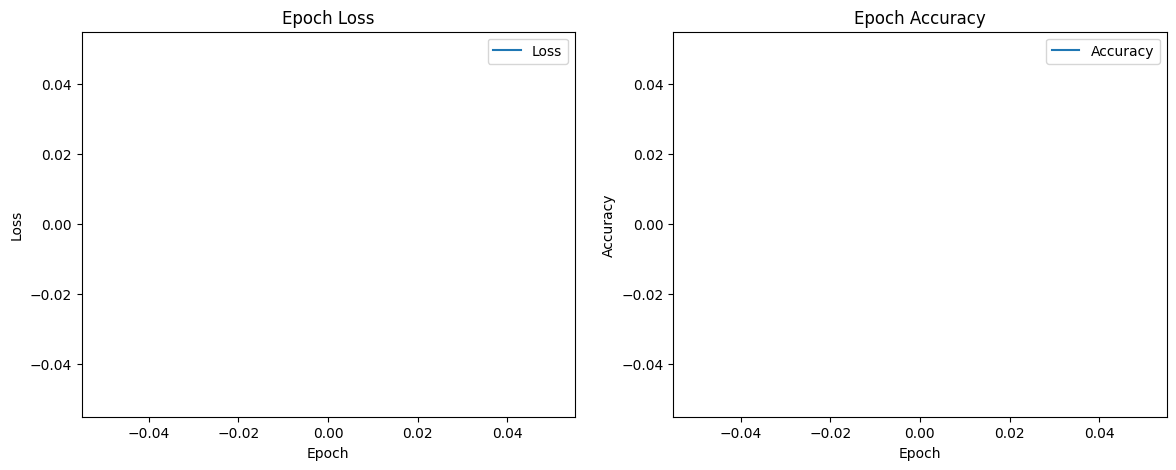

In [ ]:
# import matplotlib.pyplot as plt

# # Plotting epoch losses and accuracies
# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history['batch_loss'], label='Loss')
# plt.title('Epoch Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['batch_accuracy'], label='Accuracy')
# plt.title('Epoch Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# # You can add more plots for batch-level data, rewards, thresholds, etc.


# Visual

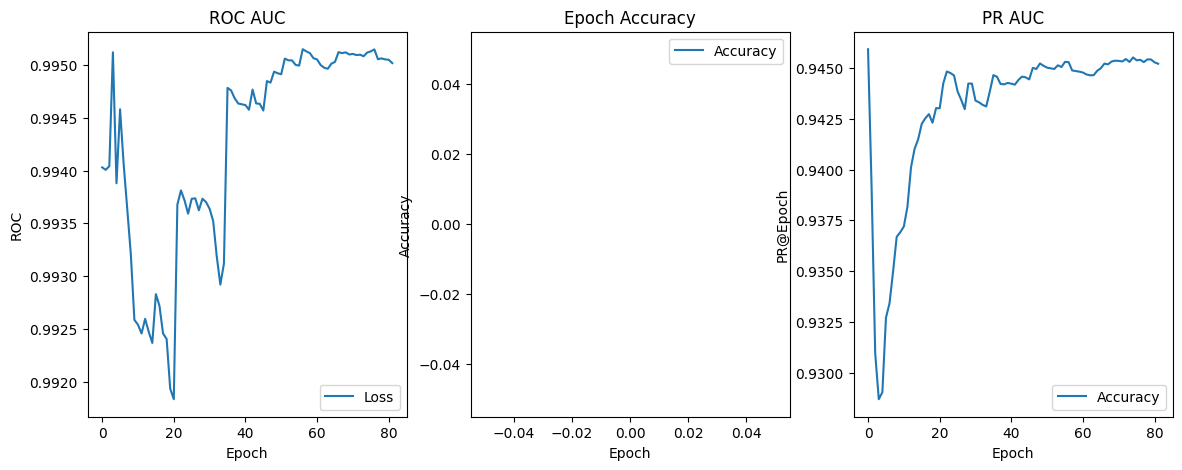

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history['ROC_AUC'], label='ROC')
plt.title('ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['PR_AUC'], label='Accuracy')
plt.title('PR AUC')
plt.xlabel('Epoch')
plt.ylabel('PR@Epoch')
plt.legend()

KeyError: 'recall'

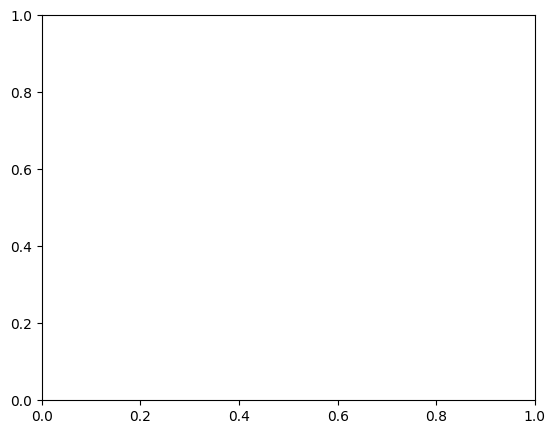

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['recall'], label='Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['f1'], label='F1')
plt.title('F1@Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(history['PR_AUC'], label='Accuracy')
# plt.title('PR AUC')
# plt.xlabel('Epoch')
# plt.ylabel('PR@Epoch')
# plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, predictions=None):
    """Plot images with their labels. Show predictions if provided."""
    n = images.shape[0]
    sqrt_val = int(np.ceil(np.sqrt(n)))
    fig, axes = plt.subplots(sqrt_val, sqrt_val, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i >= n:
            break
        ax.imshow(images[i], cmap='binary')
        
        if predictions is not None:
            ax.set_title(f"True: {labels[i]}\nPred: {predictions[i]}")
        else:
            ax.set_title(f"Label: {labels[i]}")
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Predictions from the second classifier
predictions = model_2.predict(X_test_reshaped)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Assuming binary classification

# Selecting a few images to display
indices = np.random.choice(range(len(x_test)), 25, replace=False)  # Randomly select 25 images
selected_images = x_test[indices]
selected_labels = y_test[indices]
selected_predictions = predicted_classes[indices]

# Plotting
plot_images(selected_images, selected_labels, selected_predictions)


NameError: name 'model_2' is not defined

In [ ]:
def plot_history(history):
    """Plot training and validation loss and accuracy."""
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history.history['loss'], label='train')
    axs[0].plot(history.history['val_loss'], label='validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='train')
    axs[1].plot(history.history['val_accuracy'], label='validation')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

# Assuming you have stored the history of training your models as `history_1` and `history_2`
plot_history(history_1)  # For the first classifier
plot_history(history_2)  # For the second classifier
